# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Rede-Neural-com-Regularização-L2" data-toc-modified-id="Rede-Neural-com-Regularização-L2-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Rede Neural com Regularização L2</a></div><div class="lev2 toc-item"><a href="#Preâmbulo" data-toc-modified-id="Preâmbulo-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Preâmbulo</a></div><div class="lev2 toc-item"><a href="#Notação-e-equações" data-toc-modified-id="Notação-e-equações-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Notação e equações</a></div><div class="lev3 toc-item"><a href="#Propagação-para-frente" data-toc-modified-id="Propagação-para-frente-121"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Propagação para frente</a></div><div class="lev3 toc-item"><a href="#Propagação-para-trás" data-toc-modified-id="Propagação-para-trás-122"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Propagação para trás</a></div><div class="lev2 toc-item"><a href="#Implementação" data-toc-modified-id="Implementação-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Implementação</a></div><div class="lev3 toc-item"><a href="#O-código" data-toc-modified-id="O-código-131"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>O código</a></div><div class="lev3 toc-item"><a href="#Verificando-o-cálculo-do-gradiente" data-toc-modified-id="Verificando-o-cálculo-do-gradiente-132"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Verificando o cálculo do gradiente</a></div><div class="lev2 toc-item"><a href="#Testes" data-toc-modified-id="Testes-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Testes</a></div><div class="lev3 toc-item"><a href="#Boston-Housing-Data-Set" data-toc-modified-id="Boston-Housing-Data-Set-141"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Boston Housing Data Set</a></div><div class="lev3 toc-item"><a href="#Testes" data-toc-modified-id="Testes-142"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>Testes</a></div><div class="lev3 toc-item"><a href="#Implementando-com-o-Keras" data-toc-modified-id="Implementando-com-o-Keras-143"><span class="toc-item-num">1.4.3&nbsp;&nbsp;</span>Implementando com o Keras</a></div>

# Rede Neural com Regularização L2

O objetivo deste notebook é incluir a regularização L2 na implementação matricial da rede neural apresentada
anteriormente. Esta demonstração possui ênfase nos seguintes pontos:

- Verificação numérica da corretude da implementação do cálculo dos gradientes com a formulação de custo 
  utilizando regularização L2
- Implementação equivalente no Keras para efeitos comparativos


## Preâmbulo

In [1]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython.display import display
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

import time
import numpy as np
import numpy.random as nr
import pandas as pd
import tensorflow as tf

from keras.models import Sequential
from keras.layers.core import Dense, Flatten, Dropout
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, TensorBoard
from keras.utils import np_utils
from keras.regularizers import l2

np.set_printoptions(precision=3, linewidth=100, suppress=True)

Using TensorFlow backend.


## Notação e equações

<!--
<table align='left'>
<tr><td colspan=2> <img src="https://docs.google.com/drawings/d/1958hSDd7WX_ijgL9E-SMR3sgzLvBpmvD8AyEtwaxio8/pub?w=960&h=720" alt="Drawing" style="width: 960px;"/> </td></tr>
</table>
-->

### Propagação para frente
<!--
<table align='left'>
<tr><td colspan=2> <img src="https://docs.google.com/drawings/d/1BF5HoqP0ZdiT75dwG3UJY1ZXlFBqcXPL2rH-yD_6X18/pub?w=960&amp;h=720"> </td></tr>
</table>
-->

\begin{align} 
\mathbf{a}_{(i)} & = \begin{cases}
\mathbf{x}  & \text{ if } i = 0 \\
\\
g \left( \mathbf{z}_{(i-1)} \right ) = g \left ( \mathbf{a}_{(i-1)} \cdot \mathbf{W}_{(i-1)} \right ) & \text{ if } 1 \leq i \leq L  \text{ where } g(\mathbf{z}) = \frac{1}{1+e^{-\mathbf{z}}} \\
\end{cases}
\\[3 mm]
\mathbf{\hat{y}} & = \mathbf{a}_{L}
\\[3 mm]
J & = \begin{cases}
- \frac{1}{M} \sum_{M} \sum_{K} \left ( \mathbf{y} \log{(\mathbf{\hat{y}})} + (1 - \mathbf{y}) \log{(1 - \mathbf{\hat{y}})} \right ) + \frac{1}{2M} \sum_{L} \sum \sum \mathbf{W}^{2} & \text{ for classifier with logistic activation function } \\
\\
\\
\frac{1}{2M} \sum_{M} \sum_{P} \left ( \mathbf{\hat{y}} - \mathbf{y} \right )^{2} + \frac{1}{2M} \sum_{L} \sum \sum \mathbf{W}^{2} & \text{ for regressor with linear activation function } \\
\end{cases}
\end{align}


### Propagação para trás

<!--
<table align='left'>
<tr><td colspan=2> <img src="https://docs.google.com/drawings/d/1LW6gUSfpf1edP08gk8GTjovFlZvqz9qKRRmt_YzP-l4/pub?w=960&amp;h=720"> </td></tr>
</table>
-->

\vspace{5 mm}
\begin{align} 
\boldsymbol{\delta}_{(i)} & = \begin{cases}
\frac{\partial J}{\partial z_{(i)}} = \frac{\partial J}{\partial \mathbf{a}_{(i)}}  \frac{\partial \mathbf{a}_{(i)}}{\partial \mathbf{z}_{(i)}} = \mathbf{a}_{(i)} - \mathbf{y} & \text{ if } i = L \\
\\
\left ( \boldsymbol{\delta}_{(i+1)}  \cdot \mathbf{W}_{(i)}^{T} \right ) \circ \frac{\partial \mathbf{a}_{(i)}}{\partial \mathbf{z}_{(i)}} = \left ( \boldsymbol{\delta}_{(i+1)}  \cdot \mathbf{W}_{(i)}^{T} \right ) \circ \left ( \mathbf{a}_{(i)} (1 - \mathbf{a}_{(i)}) \right ) & \text{ if } 1 \leq i \leq L-1 
\end{cases}
\\[3 mm]
\mathbf{\nabla}_{(i)} & = \frac{1}{M} \left( \mathbf{a}_{(i)}^{T} \cdot \boldsymbol{\delta}_{(i+1)} + \lambda \mathbf{W}_{(i)} \right)
\\[3 mm]
\mathbf{W}_{(i)} & = \mathbf{W}_{(i)} - \eta \mathbf{\nabla}_{(i)}
\end{align}

## Implementação

<!--
<table align='left'>
<tr>
<td colspan=2> 
<b>Forward</b>
<img src="https://docs.google.com/drawings/d/1gtCx1mmtt3pwlJwZaWOGW_OQ8sBttftRwH9uVmNPHaY/pub?w=960&h=720" alt="Drawing" style="width: 960px;"/> 
</td>

<td colspan=2> 
<b>Backward</b>
<img src="https://docs.google.com/drawings/d/1C3HOnRX9bSnsvHlyWJo9pEirXE_4ms8RJWtaqMYGpQw/pub?w=960&h=720" alt="Drawing" style="width: 960px;"/> 
</td>

</tr>
</table>
-->


### O código

In [2]:
class BackPropNeuralNetwork:
    
    def __init__(self, layer_sizes=[], is_classifier=True, lambda_=0.0):
        self.L = len(layer_sizes)
        self.s = layer_sizes
        self.W = None
        self.classifier = is_classifier
        self.costs = []
        self.set_lambda(lambda_)

    def init_weights(self, epsilon=None):
        from numpy.random import rand
        self.W = []
        for i in range(self.L-1):
            Wi = np.zeros((self.s[i+1], self.s[i]+1), np.float)
            if epsilon != 0:
                # Glorot Uniform or uniform with epsilon
                eps = epsilon or np.sqrt(6.0 / (self.s[i] + self.s[i+1]))
                Wi[:, 1:] = 2*eps*rand(self.s[i+1], self.s[i]) - eps
            self.W.append(Wi.T)
            
    def set_lambda(self, value=None):
        if value is not None:
            self.lambda_ = value
        return self.lambda_
        
    def predict(self, X):
        a = self.compute_activations(self.W, X)
        return a[-1]
    
    def evaluate(self, X, y):
        a = self.compute_activations(self.W, X)
        cost = self.compute_cost(a[-1], y)
        return cost
    
    def compute_cost_and_gradient(self, W, X, y):
        M, N  = X.shape
        G = [None for n in self.s[:-1]]
        # Forward propagation
        a = self.compute_activations(W, X)
        # Cost computation, without regularization
        J = self.compute_cost(a[-1], y)
        # Back propagation
        d = self.compute_errors(W, a, y)
        # Gradients
        for j in range(self.L-1):
            # ... add regularization to cost
            J += 0.5 * self.lambda_ * (W[j][1:,:] * W[j][1:,:]).sum() / M
            # ... compute gradient
            G[j] = np.dot(a[j].T, d[j+1]) / M                    # eq. 5
            # ... add regularization to gradient
            G[j][1:,:] += self.lambda_ * W[j][1:,:] / M
        return J, G

    def compute_cost(self, y_pred, y_true):
        M, P = y_true.shape
        if self.classifier:
            # classifier: binary cross-entropy                   # eq. 3
            J = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)).sum() / M
        else:
            # regressor: mean squared error                      # eq. 3
            J = 0.5 * np.square(y_pred - y_true).sum() / M
        return J
    
    def compute_activations(self, W, X):
        a = [None for n in self.s]
        a[0] = X                                                 # eq. 1
        for j in range(1, self.L):
            a[j-1] = np.insert(a[j-1], 0, 1, 1)
            z = np.dot(a[j-1], W[j-1])                           # eq. 1
            if j == self.L-1 and not self.classifier:
                a[j] = z
            else:
                a[j] = self._logistic(z)                         # eq. 1
        return a            

    def compute_errors(self, W, a, y):
        d = [None for n in self.s]
        d[-1] = a[-1] - y                                        # eq. 4
        for j in range(self.L-2, 0, -1):
            d[j] = np.dot(d[j+1], W[j].T) * (a[j] * (1 - a[j]))  # eq. 4
            d[j] = d[j][:,1:]
        return d

    def sgd(self, X, y, eta, batch_size, n_epochs, Xval=None, yval=None, verbose=0):
        m, n = X.shape
        n_batches = int(np.ceil(m / batch_size))
        for epoch in range(n_epochs):
            for ii in range(n_batches):
                kk = batch_size * ii
                X_batch, y_batch = X[kk:kk+batch_size], y[kk:kk+batch_size]
                
                cost, G = self.compute_cost_and_gradient(self.W, X, y)
                for i in range(len(self.W)):
                    self.W[i] -= eta * G[i]                      # eq. 6
                                
            if Xval is not None:
                cost_val = self.evaluate(Xval, yval)
                self.costs.append((epoch, cost, cost_val))
                if (verbose > 0) and (not epoch % verbose):
                    print(('{:4d} Training Cost: {:.5f}    Validation Cost: {:.5f}'.format(epoch, cost, cost_val)))
            else:
                self.costs.append((epoch, cost, 0))
                if (verbose > 0) and (not epoch % verbose):
                    print(('{:4d} Training Cost: {:.5f}'.format(epoch, cost)))

        return self.costs

    @staticmethod
    def _logistic(z):
        z = np.asarray(z)
        z = np.minimum(z,  15)
        z = np.maximum(z, -15)
        return np.ones(z.shape)/(1.0 + np.exp(-z))


### Verificando o cálculo do gradiente

Para fazer uma verificação numérica da correção de nossa implementação concatenamos cada matriz $W^{(L)}$ de forma a criar um vetor $\theta$ que contenha todos os pesos (e bias) de nossa rede neural.

Para calcular o gradiente, para cada elemento do vetor $\theta$ fazemos


$$
\theta^{(i+)} = \theta + \begin{bmatrix}
0 \\
0\\ 
\vdots \\ 
\epsilon \\ 
\vdots \\ 
0
\end{bmatrix} \; \; \; \; \; \; \text{ e }  \; \; \; \theta^{(i-)} = \theta - \begin{bmatrix}
0 \\
0\\ 
\vdots \\ 
\epsilon \\ 
\vdots \\ 
0
\end{bmatrix}
$$

Uma aproximação para o gradiente é dada por:

$$
\frac{\partial }{\partial \theta_i} J(\theta) \approx \frac{J(\theta^{(i+)}) - J(\theta^{(i-)})}{2 \epsilon}
$$

In [3]:
def compute_approx_gradient(nnet, W, X, y, eps=0.0001):
    def roll(thetas, W=W):
        Theta, m = [], 0
        for h, w in [t.shape for t in W]:
            Theta.append(thetas[m:m + h*w].reshape((h,w)))
            m += h*w
        return Theta
    
    thetas = np.concatenate([t.flat for t in W])
    agrads = np.zeros_like(thetas)
    for i in range(thetas.shape[0]):
        t_plus = thetas.copy()
        t_plus[i] += eps            
        J_plus, _ = nnet.compute_cost_and_gradient(roll(t_plus), X, y)

        t_minus = thetas.copy()
        t_minus[i] -= eps
        J_minus, _ = nnet.compute_cost_and_gradient(roll(t_minus), X, y)

        agrads[i] = (J_plus - J_minus) / (2*eps)

    return agrads

def gradient_check(lambda_, classif):
    nn = BackPropNeuralNetwork([4, 5, 3], is_classifier=classif, lambda_=lambda_)
    nn.init_weights()
    
    X = np.sin(np.arange(32)).reshape((8, 4)) / 10
    y = np.zeros((8, 3))
    for i, k in enumerate(np.mod(np.arange(8), 3)):
        y[i,k] = 1.0
    
    agrad = compute_approx_gradient(nn, nn.W, X, y)
    J, G = nn.compute_cost_and_gradient(nn.W, X, y)
    grad = np.concatenate([t.flat for t in G])
    
    return np.allclose(agrad, grad)

res = ['Error', 'OK']
print('Classificador:', res[gradient_check(0.0, True)],  res[gradient_check(0.5, True)])
print('Regressor:    ', res[gradient_check(0.0, False)], res[gradient_check(0.5, False)])


Classificador: OK OK
Regressor:     OK OK


## Testes

### Boston Housing Data Set


In [4]:
data = np.load('../data/boston_housing.npz')
Xtra, ytra = data['Xtra'], data['ytra']
Xval, yval = data['Xval'], data['yval']
M, N = Xtra.shape

### Testes

In [5]:
nr.seed(20170514)

layer_sizes = [N, 40, 1]
n_epochs = 2000
batch_size = M
lr = 0.1
lambda_a = 0.0
lambda_b = 8.0

nnet_a = BackPropNeuralNetwork(layer_sizes, is_classifier=False, lambda_=lambda_a)
nnet_a.init_weights()
W_init = [w.copy() for w in nnet_a.W]    # save the random weights to reuse in keras

nnet_b = BackPropNeuralNetwork(layer_sizes, is_classifier=False, lambda_=lambda_b)
nnet_b.W = [w.copy() for w in W_init]

print('-'*60)
print('Tuneable parameters: {}'.format(sum([w.size for w in nnet_a.W])))
print('-'*60)

try:
    t1 = t0 = time.time()
    costs_a = nnet_a.sgd(Xtra, ytra, lr, batch_size, n_epochs, Xval=Xval, yval=yval, verbose=0)
    costs_b = nnet_b.sgd(Xtra, ytra, lr, batch_size, n_epochs, Xval=Xval, yval=yval, verbose=0)
    t1 = time.time()
except KeyboardInterrupt:
    pass

print('Trained in {:2f}s\n'.format(t1-t0))

------------------------------------------------------------
Tuneable parameters: 561
------------------------------------------------------------
Trained in 6.239082s



MSE:  9.725  for lambda = 0.000
MSE:  8.665  for lambda = 8.000


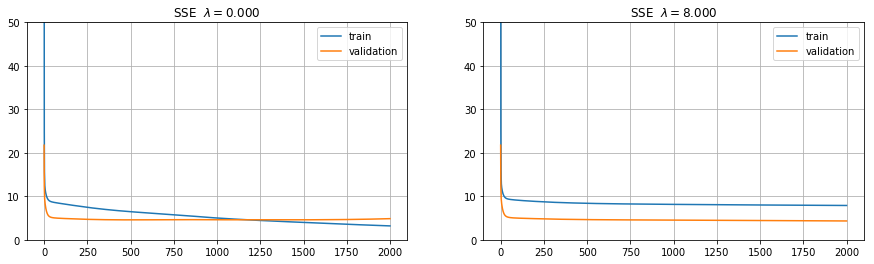

In [6]:
mse_a = np.square(nnet_a.predict(Xval) - yval).mean()
mse_b = np.square(nnet_b.predict(Xval) - yval).mean()
print('MSE: {:6.3f}  for lambda = {:.3f}'.format(mse_a, lambda_a))
print('MSE: {:6.3f}  for lambda = {:.3f}'.format(mse_b, lambda_b))

fig = plot.figure(figsize=(15,4))

fig.add_subplot(121)
plot.plot([c1 for i, c1, c2 in costs_a], label='train')
plot.plot([c2 for i, c1, c2 in costs_a], label='validation')
plot.ylim(0, 50.)
plot.legend()
plot.grid()
plot.title('SSE  $\lambda = {:.3f}$'.format(lambda_a));

fig.add_subplot(122)
plot.plot([c1 for i, c1, c2 in costs_b], label='train')
plot.plot([c2 for i, c1, c2 in costs_b], label='validation')
plot.ylim(0, 50.)
plot.legend()
plot.grid()
plot.title('SSE  $\lambda = {:.3f}$'.format(lambda_b));

### Implementando com o Keras

In [7]:
def build(lambda_=0.0):  
    model = Sequential()
    model.add(Dense(layer_sizes[1], activation='sigmoid', input_dim=layer_sizes[0], kernel_regularizer=l2(lambda_)))
    for i, nn in enumerate(layer_sizes[2:-1]):
        model.add(Dense(nn, activation='sigmoid', kernel_regularizer=l2(lambda_)))
    model.add(Dense(layer_sizes[-1], activation='linear', kernel_regularizer=l2(lambda_)))
    return model


lambda_aa = lambda_a / (2*M)
lambda_bb = lambda_b / (2*M)

nnet_a = build(lambda_aa)
nnet_b = build(lambda_bb)
nnet_a.summary()
loss = 'mse'

if 1:
    def my_mean_squared_error(y_true, y_pred):
        return tf.reduce_mean(tf.square(y_true - y_pred)) / 2.0

    loss = my_mean_squared_error
    
    # Using the initial random weights from our implementation
    weights = []
    for W in W_init:
        weights.append(W[1:, :])
        weights.append(W[0, :])
    nnet_a.set_weights(weights)
    nnet_b.set_weights(weights)

opt = SGD(lr=lr)
nnet_a.compile(loss=loss, optimizer=opt)
nnet_b.compile(loss=loss, optimizer=opt)

try:
    t0 = time.time()
    histo_a = nnet_a.fit(Xtra, ytra, batch_size=batch_size, epochs=n_epochs, verbose=0, shuffle=False,
                         validation_data=(Xval, yval), callbacks=[])
    histo_b = nnet_b.fit(Xtra, ytra, batch_size=batch_size, epochs=n_epochs, verbose=0, shuffle=False,
                         validation_data=(Xval, yval), callbacks=[])
    t1 = time.time()
except KeyboardInterrupt:
    pass

print('Trained in {:2f}s\n'.format(t1-t0))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                520       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 41        
Total params: 561
Trainable params: 561
Non-trainable params: 0
_________________________________________________________________
Trained in 15.028735s



MSE:  9.725  for lambda = 0.000
MSE:  8.665  for lambda = 0.010


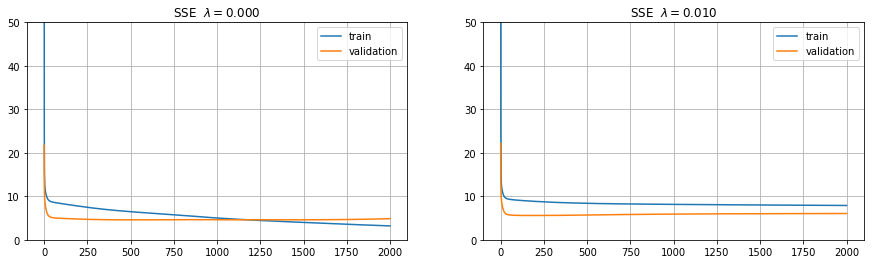

In [8]:
mse_a = np.square(nnet_a.predict(Xval, verbose=0) - yval).mean()
mse_b = np.square(nnet_b.predict(Xval, verbose=0) - yval).mean()
print('MSE: {:6.3f}  for lambda = {:.3f}'.format(mse_a, lambda_aa))
print('MSE: {:6.3f}  for lambda = {:.3f}'.format(mse_b, lambda_bb))

fig = plot.figure(figsize=(15,4))

fig.add_subplot(121)
plot.plot(histo_a.history['loss'], label='train')
plot.plot(histo_a.history['val_loss'], label='validation')
plot.ylim(0, 50.)
plot.legend()
plot.grid()
plot.title('SSE  $\lambda = {:.3f}$'.format(lambda_aa));

fig.add_subplot(122)
plot.plot(histo_b.history['loss'], label='train')
plot.plot(histo_b.history['val_loss'], label='validation')
plot.ylim(0, 50.)
plot.legend()
plot.grid()
plot.title('SSE  $\lambda = {:.3f}$'.format(lambda_bb));

## Aprendizados